In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
from scipy.io import loadmat
from scipy.stats import binned_statistic

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import model, utils, inference

from importlib import reload
reload(model)

<module 'model' from '/storage/coda1/p-awu36/0/cli726/vis/pohawkes/model.py'>

In [2]:
## arguments
method_list = np.array(['VI', 'CHIVI', 'VBIS', 'VIS'])
n_hid_neurons_list = [1, 2, 3]
seed_list = np.arange(10)

In [6]:
df_list = []
for method in method_list:
    for n_hid_neurons in n_hid_neurons_list:
        for seed in seed_list:
            try:
                df_temp = pd.read_csv(f'csv/rgc_{method}_{n_hid_neurons}_{seed}.csv')
                df_temp['method'] = method
                df_temp['$n$ hidden neurons'] = n_hid_neurons
                df_temp['seed'] = seed
                df_list.append(df_temp)
            except:
                print(method, n_hid_neurons, seed)

df = pd.concat(df_list, ignore_index=True)

In [7]:
def load_data():
    temp = loadmat(f'SpTimesRGC.mat', squeeze_me=False, struct_as_record=False)['SpTimes'][0]
    n_time_bins = 20 * 60 * 120 # 20 min * 119.9820 Hz
    time_bins = np.linspace(1, n_time_bins, n_time_bins)
    n_neurons = 27
    spikes = np.zeros((n_time_bins, n_neurons))
    for i in range(n_neurons):
        spikes[:, i] = binned_statistic(temp[i][:, 0], None, bins=np.hstack(([0], time_bins)), statistic='count')[0].T
    return spikes

spikes = load_data()

## hyper-parameters
decay = 5
# dt = 1/120
dt = 0.05
window_size = 1
n_vis_neurons = spikes.shape[1]
n_hid_neurons = 1
n_neurons = n_vis_neurons + n_hid_neurons
basis = utils.exp_basis(decay, window_size, dt*window_size)


vis_spikes_list_train, vis_spikes_list_test = torch.from_numpy(spikes[:96000].reshape(960, 100, -1)).to(torch.float32), torch.from_numpy(spikes[96000:].reshape(480, 100, -1)).to(torch.float32)
convolved_vis_spikes_list_train = utils.convolve_spikes_with_basis(vis_spikes_list_train, basis)
convolved_vis_spikes_list_test = utils.convolve_spikes_with_basis(vis_spikes_list_test, basis)

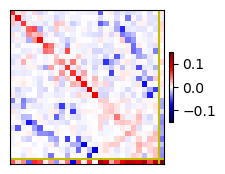

In [8]:
def visualize_linear(w, ax, v=0.15):
    im = ax.matshow(w, cmap='seismic', vmin=-v, vmax=v)
    ax.tick_params(left=False, top=False, bottom=False, labelleft=False, labeltop=False)
    ax.hlines(y=[26.5], xmin=[-0.5], xmax=[27.5], colors='y')
    ax.vlines(x=[26.5], ymin=[-0.5], ymax=[27.5], colors='y')
    return im


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
im = visualize_linear(torch.load(f'model/rgc_{method}_{n_hid_neurons}_{seed}_inf.pt')['linear.weight'], ax)
fig.colorbar(im, cax=fig.add_axes([0.92, 0.32, 0.02, 0.35]), orientation='vertical')

# fig.savefig('poglm_w.pdf', bbox_inches='tight', transparent=True)

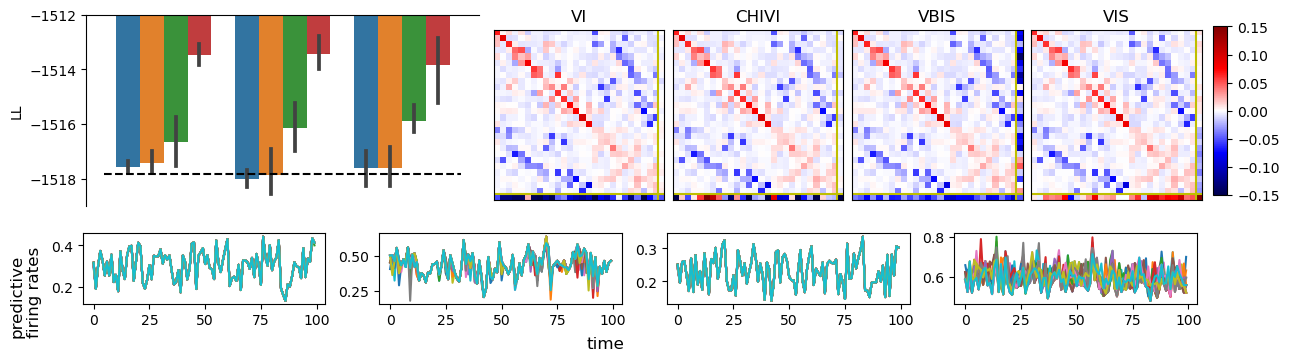

In [20]:
seed = 4
n_hid_neurons = 1
n_vis_neurons = 27
n_neurons = n_vis_neurons + n_hid_neurons
sample = 0

fig = plt.figure(layout='constrained', figsize=(12, 3.5))
subfigs = fig.subfigures(2, 1, hspace=0.05, height_ratios=[1, 0.6])

subsubfigs = subfigs[0].subfigures(1, 2, wspace=0.01, width_ratios=[1, 1.5])

## barplot
ax = subsubfigs[0].subplots(1, 1)
sns.barplot(data=df, x='$n$ hidden neurons', y='marginal log-likelihood', hue='method', ax=ax)
baseline = pd.read_csv(f'csv/rgc_0.csv').iat[0, 0]
ax.plot([-0.5, 2.5], [baseline, baseline], 'k--')
ax.set_ylim(-1519, -1512)
ax.set(xlabel=None)
ax.set_ylabel('LL')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)
ax.get_legend().remove()

## weight
axs = subsubfigs[1].subplots(1, 4)
for i, method in enumerate(method_list):
    im = visualize_linear(torch.load(f'model/rgc_{method}_{n_hid_neurons}_{seed}_inf.pt')['linear.weight'], axs[i])
    axs[i].set_title(f'{method}')
subsubfigs[1].colorbar(im, cax=subsubfigs[1].add_axes([1.01, 0.11, 0.02, 0.79]), orientation='vertical')

## firing rates
axs = subfigs[1].subplots(1, 4, sharex=True)
for method, ax in zip(method_list, axs):

    vari_model = model.ForwardSelf(n_neurons, n_vis_neurons, basis)
    vari_model.load_state_dict(torch.load(f'model/rgc_{method}_{n_hid_neurons}_{seed}_vari.pt'))

    vis_spikes = vis_spikes_list_test[sample]
    convolved_vis_spikes = convolved_vis_spikes_list_test[sample]

    with torch.no_grad():
        torch.manual_seed(0)
        hid_spikes_list, convolved_hid_spikes_list, hid_firing_rates_list = vari_model.sample(convolved_vis_spikes, n_samples=20)
        for j in range(20):
            spikes = torch.cat((vis_spikes, hid_spikes_list[j]), dim=1)
            firing_rates_pred = vari_model.forward(spikes)
            ax.plot(firing_rates_pred[:, 0])
subfigs[1].supxlabel('time')
subfigs[1].supylabel('predictive\nfiring rates')

fig.savefig('poglm_rgc.pdf', bbox_inches='tight', transparent=True)